# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
# These libraries may be useful to you

from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from collections import Counter, defaultdict

nlp = spacy.load('en_core_web_sm')

In [2]:
# add any additional libaries you need here

import seaborn as sns
import plotly.express as px

In [3]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [4]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [5]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [6]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


Now do our TF-IDF and Count vectorizations.

<AxesSubplot: xlabel='category'>

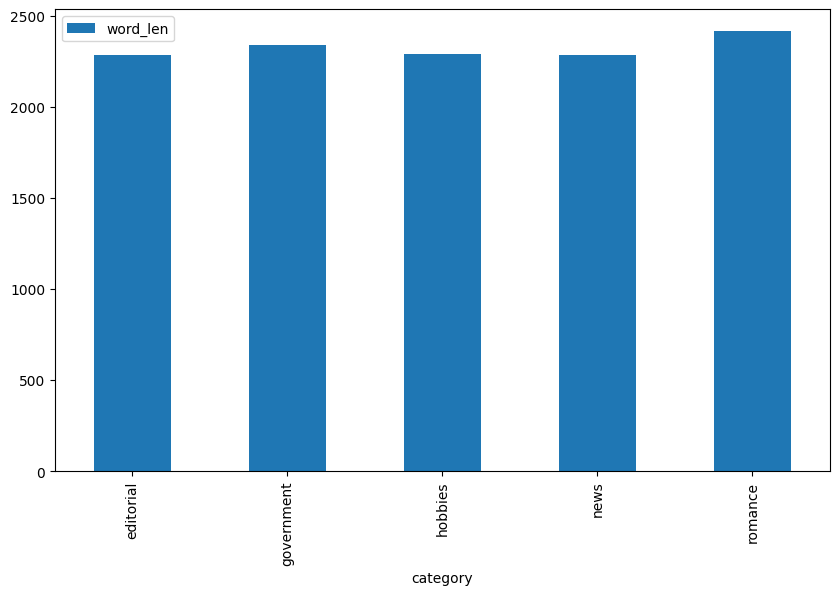

In [8]:
%matplotlib inline

df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

In [9]:
count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df['text'])
count_text_vectors.shape

C:\Users\zfreitas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(166, 4941)

In [10]:
count_text_vectorizer.get_feature_names_out()

array(['00', '000', '10', ..., 'youth', 'zone', 'zoning'], dtype=object)

In [11]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
print(tfidf_text_vectors.shape)


(166, 4941)


In [12]:
tfidf_text_vectorizer.fit(df['text']).get_feature_names_out()

array(['00', '000', '10', ..., 'youth', 'zone', 'zoning'], dtype=object)

In [13]:
tfidf_text_vectorizer.get_feature_names_out()

array(['00', '000', '10', ..., 'youth', 'zone', 'zoning'], dtype=object)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: `count_text_vectors` is a python object that contains a 166x4941 sparse matrix of type '<class 'numpy.int64'>' with 72541 stored elements in Compressed Sparse Row format. The numbers are a matrix of text documents to token counts. This matrix doesn’t include words from our stopwords list. It also ignores terms that have a document frequency strictly lower than 5. It also ignores terms that have a document frequency strictly higher than 70%.


`tfidf_text_vectors` is a python object that contains a 166x4941 sparse matrix of type '<class 'numpy.int64'>' with 72541 stored elements in Compressed Sparse Row format. The numbers are a matrix of term-frequency times inverse document-frequency. This matrix doesn’t include words from our stopwords list. It also ignores terms that have a document frequency strictly lower than 5. It also ignores terms that have a document frequency strictly higher than 70%.


## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [14]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_nmf_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_nmf_text_matrix = nmf_text_model.components_

In [15]:
# Plot PCA of Predictions
fig = px.scatter(W_nmf_text_matrix, x=0, y=1, color=df["category"])
fig.show()

C:\Users\zfreitas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\zfreitas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [16]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out(), no_top_words=5)


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.39)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.63)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.02)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF factorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 


<AxesSubplot: xlabel='Predicted Label: Model Topics', ylabel='True Label: Original Brown Topics'>

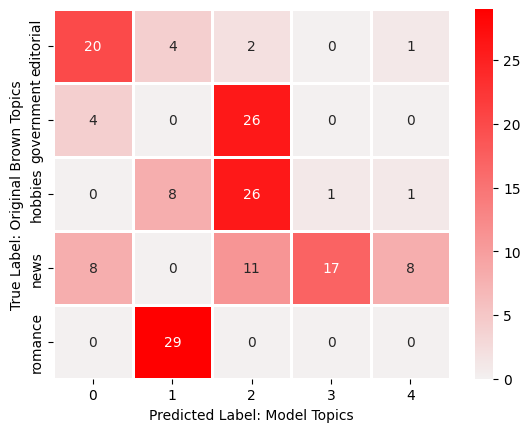

In [17]:
# Your code here
df_new = df.copy()

# Get the top predicted topic
predicted_topics = [np.argsort(each)[::-1][0] for each in W_nmf_text_matrix]

# Add to the df
df_new['nmf_pred_topic_num'] = predicted_topics

# Create Crosstab
acc_crosstab = pd.crosstab(df_new["category"], df_new["nmf_pred_topic_num"], dropna=False)

# Custom Color Palette
hot_palette =  sns.color_palette("light:r", as_cmap=True)

# Plot Heatmap of Aggreement.
ax = sns.heatmap(acc_crosstab,cmap=hot_palette,linewidths=1,annot=True)
ax.set(xlabel="Predicted Label: Model Topics", ylabel="True Label: Original Brown Topics")
ax

Q: How does your five-topic NMF model compare to the original Brown categories? 

A: Looking at the NMF model compared to the original Brown categories, it appears that our model does a good job predicting the Romance and Editorial categories. Our model seems to have a hard time differentiating between hobbies and government categories and struggles reliably predicting the news category.

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [18]:
# Your code here
lsa_text_model = TruncatedSVD(n_components=5, n_iter=7, random_state=42)
W_lsa_text_matrix = lsa_text_model.fit_transform(tfidf_text_vectors)
H_lsa_text_matrix = lsa_text_model.components_


In [19]:
# Plot PCA of Predictions
fig = px.scatter(W_lsa_text_matrix, x=0, y=1, color=df["category"])
fig.show()

C:\Users\zfreitas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\zfreitas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [20]:
display_topics(lsa_text_model, tfidf_text_vectorizer.get_feature_names_out(), no_top_words=5)


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.14)
  mr (1.73)
  said (1.04)
  kennedy (0.81)
  laos (0.77)

Topic 03
  mrs (29.56)
  club (6.57)
  game (6.15)
  jr (5.64)
  dallas (5.31)

Topic 04
  game (4.38)
  league (3.14)
  baseball (3.12)
  ball (2.98)
  team (2.85)


<AxesSubplot: xlabel='Predicted Label: Model Topics', ylabel='True Label: Original Brown Topics'>

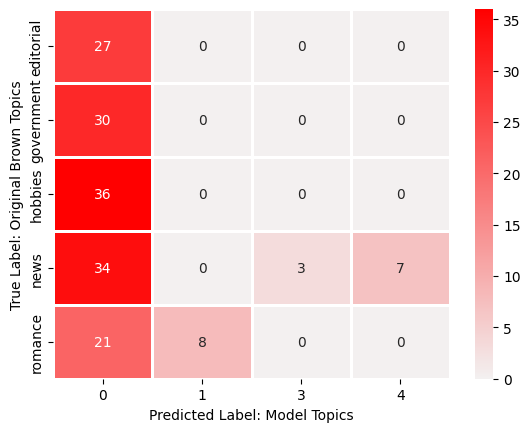

In [21]:
# Your code here
df_new = df.copy()

# Get the top predicted topic
predicted_topics = [np.argsort(each)[::-1][0] for each in W_lsa_text_matrix]

# Add to the df
df_new['lsa_pred_topic_num'] = predicted_topics

# Create Crosstab
acc_crosstab = pd.crosstab(df_new["category"], df_new["lsa_pred_topic_num"], dropna=False)

# Custom Color Palette
hot_palette =  sns.color_palette("light:r", as_cmap=True)

# Plot Heatmap of Aggreement.
ax = sns.heatmap(acc_crosstab,cmap=hot_palette,linewidths=1,annot=True)
ax.set(xlabel="Predicted Label: Model Topics", ylabel="True Label: Original Brown Topics")
ax

Q: How does your five-topic LSA model compare to the original Brown categories? 

A: This model did a terrible job of finding topics that align with the original categories. 

Q: What is your interpretation of the display topics output? 

A: 

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [22]:
# Fit your LDA model here

lda_text_model = LatentDirichletAllocation(n_components=5, random_state=0)
W_lda_text_matrix = lda_text_model.fit_transform(tfidf_text_vectors)
H_lda_text_matrix = lda_text_model.components_

In [23]:
# Plot PCA of Predictions
fig = px.scatter(W_lda_text_matrix, x=0, y=1, color=df["category"])
fig.show()

C:\Users\zfreitas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\zfreitas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [24]:
# Call `display_topics` on your fitted model here
display_topics(lda_text_model, tfidf_text_vectorizer.get_feature_names_out(), no_top_words=5)


Topic 00
  discretion (0.02)
  construct (0.02)
  categories (0.02)
  founder (0.02)
  combinations (0.02)

Topic 01
  said (0.27)
  mr (0.16)
  state (0.15)
  mrs (0.14)
  president (0.11)

Topic 02
  discretion (0.02)
  construct (0.02)
  categories (0.02)
  founder (0.02)
  combinations (0.02)

Topic 03
  discretion (0.02)
  construct (0.02)
  categories (0.02)
  founder (0.02)
  combinations (0.02)

Topic 04
  discretion (0.02)
  construct (0.02)
  categories (0.02)
  founder (0.02)
  combinations (0.02)


<AxesSubplot: xlabel='Predicted Label: Model Topics', ylabel='True Label: Original Brown Topics'>

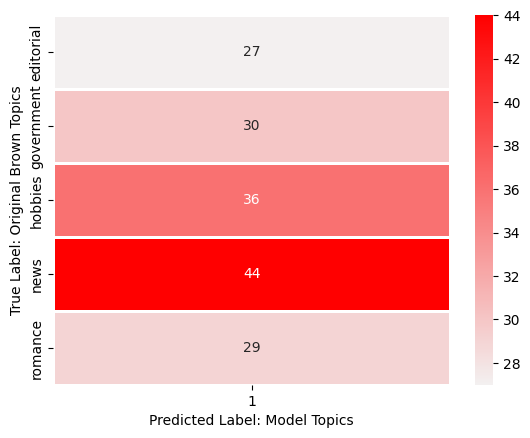

In [25]:
# Your code here
df_new = df.copy()

# Get the top predicted topic
predicted_topics = [np.argsort(each)[::-1][0] for each in W_lda_text_matrix]

# Add to the df
df_new['lda_pred_topic_num'] = predicted_topics

# Create Crosstab
acc_crosstab = pd.crosstab(df_new["category"], df_new["lda_pred_topic_num"], dropna=False)

# Custom Color Palette
hot_palette =  sns.color_palette("light:r", as_cmap=True)

# Plot Heatmap of Aggreement.
ax = sns.heatmap(acc_crosstab,cmap=hot_palette,linewidths=1,annot=True)
ax.set(xlabel="Predicted Label: Model Topics", ylabel="True Label: Original Brown Topics")
ax

Q: What inference do you draw from the displayed topics for your LDA model? 

A: The LDA model suggest that there really isn't much statistical differneces in terms between the topics choosen.

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

A: LDA has only one

In [26]:
# I'm not able to run this procedure with my setup. 
# I'm not willing to unistall and reinstall another version of python as I use this set-up for my work and I'm using my work computer to complete this project.
lda_display = pyLDAvis.sklearn.prepare(lda_text_model, tfidf_text_vectors, tfidf_text_vectorizer, sort_topics=False)
pyLDAvis.display(lda_display)

AttributeError: 'TfidfVectorizer' object has no attribute 'get_feature_names'

# Note:
I'm not able to get pyLDAvis.sklearn to work on my machine, so I tempoarily switch to gensim LDA to finish my project.

In [69]:
df

,category,id,text,char_len,word_len
0,editorial,cb01,Assembly session brought much good The General...,12659,2200
1,editorial,cb02,Must Berlin remain divided ? ? The inference h...,12544,2234
2,editorial,cb03,"A good man departs . Goodby , Mr. Sam . Sam Ra...",11871,2244
3,editorial,cb04,A shock wave from Africa Word of Dag Hammarskj...,12284,2230
4,editorial,cb05,Help when needed If the Dominican Republic ach...,12479,2241
...,...,...,...,...,...
161,hobbies,ce32,"Throughout history , the man who showed superi...",13629,2339
162,hobbies,ce33,Sixty miles north of New York City where the w...,11845,2233
163,hobbies,ce34,"In the period since the end of World War 2 , -...",13029,2300
164,hobbies,ce35,New rule no. 2 : : Don't build from the outsid...,11800,2272


In [70]:
#function for lemmatization
import gensim
import gensim.corpora as corpora

#cleaning the text 

def tokeniz(sentences):

    for sentence in sentences:

        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

#function to filter out stopwords

def remove_stopwords(texts):

    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stopwords] for doc in texts]

#removing stopwords, creating bigrams and lemmatizing the text


processed_data  = list(tokeniz(df["text"]))
data_wo_stopwords = remove_stopwords(processed_data)


#creating a dictionary

gensim_dictionary = corpora.Dictionary(data_wo_stopwords)

#building a corpus for the topic model

texts = data_wo_stopwords
gensim_corpus = [gensim_dictionary.doc2bow(text) for text in texts]

In [71]:
#creating the LDA model 

import pyLDAvis.gensim_models
from gensim.test.utils import common_corpus
import gensim.models.ldamodel

lda_model = gensim.models.ldamodel.LdaModel(

   corpus=gensim_corpus, id2word=gensim_dictionary, num_topics=5, random_state=100, 

   update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True

)

In [74]:
from pyLDAvis.gensim_models import prepare
vis = prepare(lda_model, gensim_corpus, gensim_dictionary)#, mds='pcoa')
vis.topic_info


C:\Users\zfreitas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyLDAvis\_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



,Term,Freq,Total,Category,logprob,loglift
587,said,739.000000,739.000000,Default,30.0000,30.0000
3479,mrs,207.000000,207.000000,Default,29.0000,29.0000
392,like,365.000000,365.000000,Default,28.0000,28.0000
366,john,156.000000,156.000000,Default,27.0000,27.0000
19993,hanover,73.000000,73.000000,Default,26.0000,26.0000
...,...,...,...,...,...,...
2468,miles,19.599257,56.844913,Topic5,-6.5172,1.4462
455,new,25.251300,638.640565,Topic5,-6.2638,-0.7194
392,like,23.732627,365.565707,Topic5,-6.3258,-0.2235
58,available,20.709302,117.166952,Topic5,-6.4621,0.7780


In [75]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.129095 -0.049109       1        1  43.297605
1     -0.073106 -0.079617       2        1  19.998992
0      0.194976 -0.045030       3        1  16.945028
3      0.032264  0.016934       4        1  11.640133
2     -0.025040  0.156823       5        1   8.118241, topic_info=            Term        Freq       Total Category  logprob  loglift
587         said  739.000000  739.000000  Default  30.0000  30.0000
3479         mrs  207.000000  207.000000  Default  29.0000  29.0000
392         like  365.000000  365.000000  Default  28.0000  28.0000
366         john  156.000000  156.000000  Default  27.0000  27.0000
19993    hanover   73.000000   73.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
2468       miles   19.599257   56.844913   Topic5  -6.5172   1.4462
455          new   25.251300  638.640565   Topic5  -6.2638  -0.7194
392         like   23.732627  365.565707   Topic5  -6.3258  -0.2235
58     available   20.709302  117.166952   Topic5  -6.4621   0.7780
3393        feet   19.176909   91.692695   Topic5  -6.5389   0.9463

[396 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
1818      1  0.936145   act
1818      2  0.023600   act
1818      3  0.015734   act
1818      4  0.007867   act
1818      5  0.007867   act
...     ...       ...   ...
734       1  0.527099  york
734       2  0.102491  york
734       3  0.051246  york
734       4  0.226945  york
734       5  0.087850  york

[876 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 1, 4, 3])

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: I conclude that all of the documents share a large part of thier vocabulary and that there is not much differentiation between the topics.
